In [7]:
import torch
import numpy as np
import random
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# CHANGED: Import RoBERTa instead of BERT
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast

# Fix random seeds
SEED = 50
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
from google.colab import drive
drive.mount('/content/drive')

# CHANGED: Path points to Sarcasm RoBERTa data
DATA_PATH = "/content/drive/MyDrive/DNLP/data/processed_data/sarcasm_roberta_encoder_data.pt"
WEIGHTS_PATH = "/content/drive/MyDrive/DNLP/data/processed_data/sarcasm_weights.pt"

encoder_data = torch.load(DATA_PATH)
# Load weights (same as before, these are dataset-dependent, not model-dependent)
class_weights = torch.load(WEIGHTS_PATH).to(device)

print("Keys in loaded data:", encoder_data.keys())
print("Loaded class weights:", class_weights)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Keys in loaded data: dict_keys(['train', 'val', 'test'])
Loaded class weights: tensor([0.5836, 3.4891], device='cuda:0')


In [9]:
class SarcasmDataset(Dataset):
    def __init__(self, split_data):
        self.input_ids = split_data["input_ids"]
        self.attention_mask = split_data["attention_mask"]
        self.labels = split_data["labels"]
        # Variety might be optional depending on your preprocessing,
        # but your evaluation code expects it later.
        self.variety = split_data.get("variety", None)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }
        if self.variety is not None:
            item["variety"] = self.variety[idx]
        return item

# Create DataLoaders
BATCH_SIZE = 16

train_dataset = SarcasmDataset(encoder_data["train"])
val_dataset = SarcasmDataset(encoder_data["val"])
test_dataset = SarcasmDataset(encoder_data["test"])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

Train samples: 8004
Val samples:   890
Test samples:  1216


In [ ]:
# CHANGED: Use RoBERTa architecture
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
)
model.to(device)

# Loss and Optimizer (Same as BERT baseline)
weighted_loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

print("RoBERTa model loaded and optimizer ready.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa model loaded and optimizer ready.


In [ ]:
# Training Helper Functions
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=mask)
        loss = loss_fn(outputs.logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=mask)
            all_logits.append(outputs.logits)
            all_labels.append(labels)

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    preds = torch.argmax(all_logits, dim=1).cpu().numpy()
    true_labels = all_labels.cpu().numpy()

    return accuracy_score(true_labels, preds), f1_score(true_labels, preds, average="macro")

# --- MAIN TRAINING LOOP ---
NUM_EPOCHS = 30
PATIENCE = 5
CHECKPOINT_DIR = "/content/drive/MyDrive/DNLP/checkpoints"
if not os.path.exists(CHECKPOINT_DIR): os.makedirs(CHECKPOINT_DIR)

# CHANGED: Save file name
SAVE_PATH = f"{CHECKPOINT_DIR}/best_roberta_sarcasm.pt"
HISTORY_PATH = f"{CHECKPOINT_DIR}/history_roberta_sarcasm.pt"

history = {"train_loss": [], "val_acc": [], "val_f1": []}
best_val_f1 = 0.0
epochs_no_improve = 0

print("Starting RoBERTa Sarcasm Training...")
epoch_bar = tqdm(range(1, NUM_EPOCHS + 1), desc="Training")

for epoch in epoch_bar:
    train_loss = train_one_epoch(model, train_loader, optimizer, weighted_loss_fn, device)
    val_acc, val_f1 = evaluate(model, val_loader, device)

    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    epoch_bar.set_postfix({"loss": f"{train_loss:.4f}", "val_f1": f"{val_f1:.4f}"})

    # Early Stopping Logic
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), SAVE_PATH)
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch}.")
        break

print(f"Best Validation F1: {best_val_f1:.4f}")
torch.save(history, HISTORY_PATH)

Starting RoBERTa Sarcasm Training...


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy: 0.8355
Test Macro F1: 0.7122


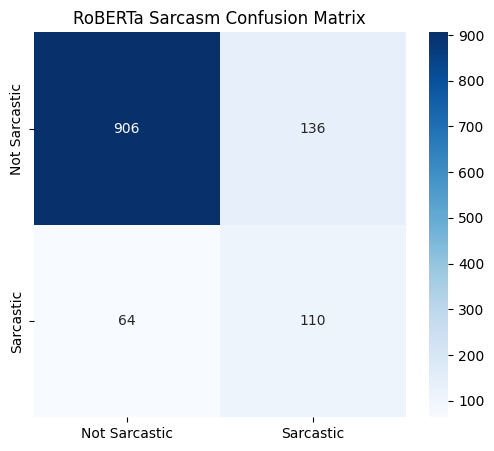

/tmp/ipython-input-1341452844.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_variety_f1 = results_df.groupby('variety_id').apply(


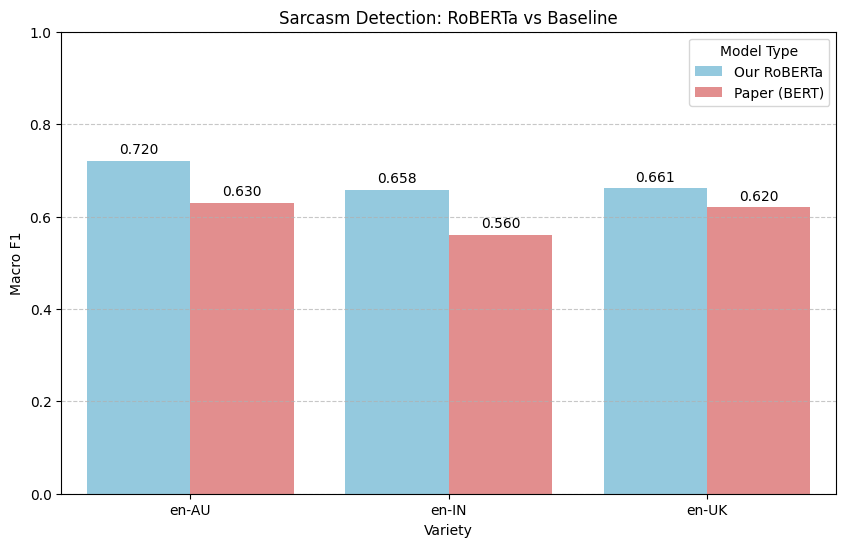

In [10]:
# Load Best Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.load_state_dict(torch.load(SAVE_PATH))
model.to(device)
model.eval()

# Evaluation Function that captures Varieties
def evaluate_detailed(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    all_varieties = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            if "variety" in batch:
                all_varieties.extend(batch["variety"].cpu().tolist())

            outputs = model(input_ids=input_ids, attention_mask=mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds, all_varieties

# Run Inference
labels, preds, varieties = evaluate_detailed(model, test_loader)

# Global Metrics
print(f"Test Accuracy: {accuracy_score(labels, preds):.4f}")
print(f"Test Macro F1: {f1_score(labels, preds, average='macro'):.4f}")

# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Sarcastic", "Sarcastic"],
            yticklabels=["Not Sarcastic", "Sarcastic"])
plt.title("RoBERTa Sarcasm Confusion Matrix")
plt.show()

# --- Per-Variety Comparison ---
# Mapping (Adjust if your IDs differ, using assumption from your notebook)
variety_map = {0: 'en-AU', 1: 'en-IN', 2: 'en-UK'}

if varieties:
    results_df = pd.DataFrame({'label': labels, 'pred': preds, 'variety_id': varieties})

    # Calculate F1 per variety
    per_variety_f1 = results_df.groupby('variety_id').apply(
        lambda x: f1_score(x['label'], x['pred'], average="macro")
    )

    # Structure Data for Plotting
    plot_data = []
    for var_id, score in per_variety_f1.items():
        plot_data.append({
            "Variety": variety_map.get(var_id, str(var_id)),
            "Macro F1": score,
            "Model Type": "Our RoBERTa"
        })

    # Add Paper Baselines (from your previous notebook for comparison)
    # Note: These numbers are for BERT, but good for context
    paper_baselines = {'en-AU': 0.63, 'en-IN': 0.56, 'en-UK': 0.62}
    for var, score in paper_baselines.items():
        plot_data.append({
            "Variety": var,
            "Macro F1": score,
            "Model Type": "Paper (BERT)"
        })

    df_plot = pd.DataFrame(plot_data)

    # Bar Chart
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df_plot, x="Variety", y="Macro F1", hue="Model Type",
                     palette={"Our RoBERTa": "skyblue", "Paper (BERT)": "lightcoral"})
    plt.title("Sarcasm Detection: RoBERTa vs Baseline")
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
    plt.show()

In [11]:
from transformers import RobertaTokenizerFast

# Load tokenizer to decode the tensor IDs back to text
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

def show_top_errors(model, dataloader, device, num_examples=5):
    model.eval()
    errors = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=mask)
            # Get probabilities with softmax
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Find indices where predictions were wrong
            incorrect_mask = preds != labels
            incorrect_indices = incorrect_mask.nonzero(as_tuple=True)[0]

            for idx in incorrect_indices:
                confidence = probs[idx][preds[idx]].item()
                # Decode text (skip special tokens like <s> and </s>)
                text = tokenizer.decode(input_ids[idx], skip_special_tokens=True)

                errors.append({
                    "text": text,
                    "true_label": labels[idx].item(),
                    "pred_label": preds[idx].item(),
                    "confidence": confidence
                })

    # Sort by confidence (show errors where the model was WRONGLY CONFIDENT)
    errors.sort(key=lambda x: x["confidence"], reverse=True)

    print(f"\nTop {num_examples} High-Confidence Errors:")
    print("-" * 60)
    for i, err in enumerate(errors[:num_examples]):
        label_map = {0: "Not Sarcastic", 1: "Sarcastic"}
        print(f"Example {i+1}:")
        print(f"Text:   {err['text']}")
        print(f"True:   {label_map[err['true_label']]}")
        print(f"Pred:   {label_map[err['pred_label']]} (Confidence: {err['confidence']:.4f})")
        print("-" * 60)

# Run the analysis
show_top_errors(model, test_loader, device)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Top 5 High-Confidence Errors:
------------------------------------------------------------
Example 1:
Text:   Non veg is good option if you go here. Taste, quality & quantity all good per price.. good service n nice Ambience after upgrading. Can have a good time enjoying with your friends & family.. please do n't but fruit juice. It's the worst you can order it was like rasna!
True:   Sarcastic
Pred:   Not Sarcastic (Confidence: 0.9995)
------------------------------------------------------------
Example 2:
Text:   Surreal is an excellent restaurant and the food is superb and service is efficient however on my third visit in Autumn the room was very cold to the point of having to leave a scarf and jacket on. Two small RC with only one turned on is not going to heat a former church chapel and a projector screen slide of an open fire really does n't cut it. Unless the heating is improved it not the place to visit in Autumn and Winter unfortunately.
True:   Sarcastic
Pred:   Not Sarcasti

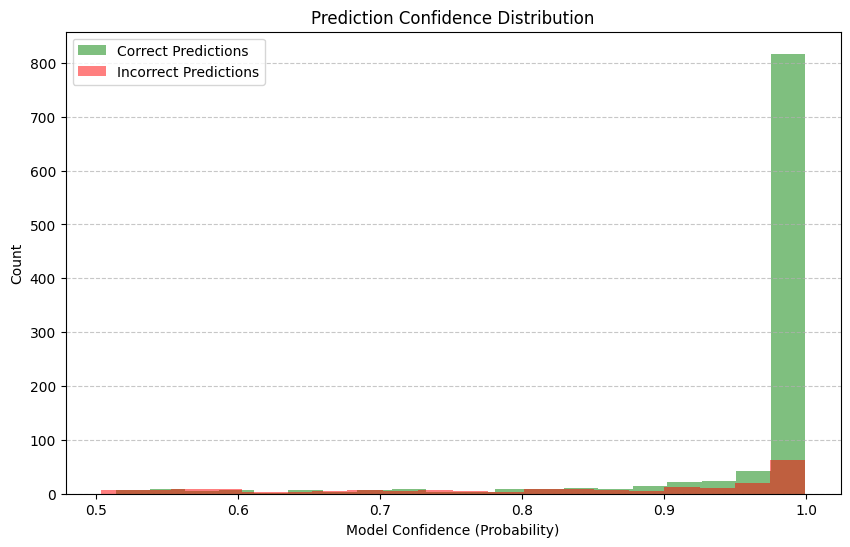

In [12]:
def plot_confidence_distribution(model, dataloader, device):
    model.eval()
    correct_confidences = []
    incorrect_confidences = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)

            # Get the probability of the predicted class
            max_probs, preds = torch.max(probs, dim=1)

            for i in range(len(labels)):
                if preds[i] == labels[i]:
                    correct_confidences.append(max_probs[i].item())
                else:
                    incorrect_confidences.append(max_probs[i].item())

    plt.figure(figsize=(10, 6))
    plt.hist(correct_confidences, bins=20, alpha=0.5, label='Correct Predictions', color='green')
    plt.hist(incorrect_confidences, bins=20, alpha=0.5, label='Incorrect Predictions', color='red')
    plt.xlabel('Model Confidence (Probability)')
    plt.ylabel('Count')
    plt.title('Prediction Confidence Distribution')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_confidence_distribution(model, test_loader, device)

/tmp/ipython-input-514862328.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_acc = df_len.groupby('bin')['correct'].mean()


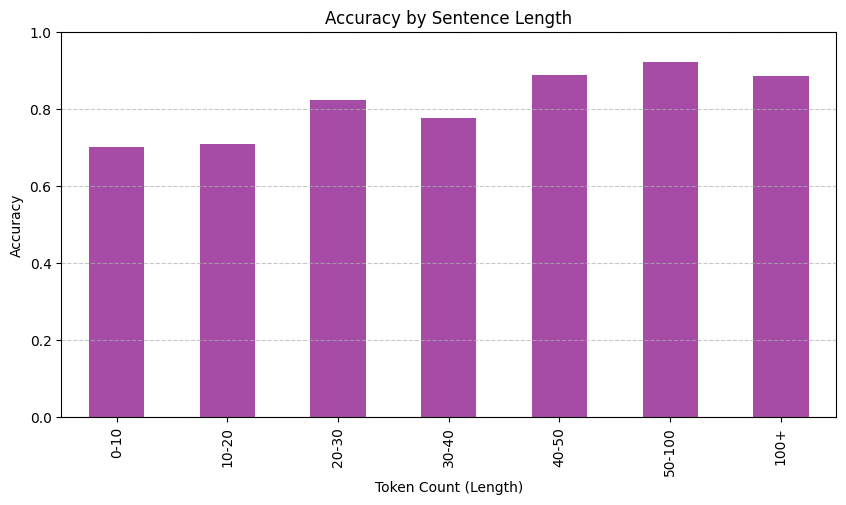

In [13]:
def plot_performance_by_length(model, dataloader, device):
    model.eval()
    lengths = []
    is_correct = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=mask)
            preds = torch.argmax(outputs.logits, dim=1)

            # Calculate real length (ignoring padding)
            batch_lengths = mask.sum(dim=1).cpu().numpy()
            batch_correct = (preds == labels).cpu().numpy()

            lengths.extend(batch_lengths)
            is_correct.extend(batch_correct)

    df_len = pd.DataFrame({'length': lengths, 'correct': is_correct})

    # Bin lengths into groups (e.g., 0-10 tokens, 10-20 tokens)
    bins = [0, 10, 20, 30, 40, 50, 100, 512]
    labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-100', '100+']
    df_len['bin'] = pd.cut(df_len['length'], bins=bins, labels=labels)

    # Calculate accuracy per bin
    bin_acc = df_len.groupby('bin')['correct'].mean()

    plt.figure(figsize=(10, 5))
    bin_acc.plot(kind='bar', color='purple', alpha=0.7)
    plt.title('Accuracy by Sentence Length')
    plt.xlabel('Token Count (Length)')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_performance_by_length(model, test_loader, device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Analyzing vocabulary...


/tmp/ipython-input-1504500566.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[1] for x in sarc_counts], y=[x[0] for x in sarc_counts], ax=axes[0], palette="Reds_r")
/tmp/ipython-input-1504500566.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[1] for x in reg_counts], y=[x[0] for x in reg_counts], ax=axes[1], palette="Greens_r")


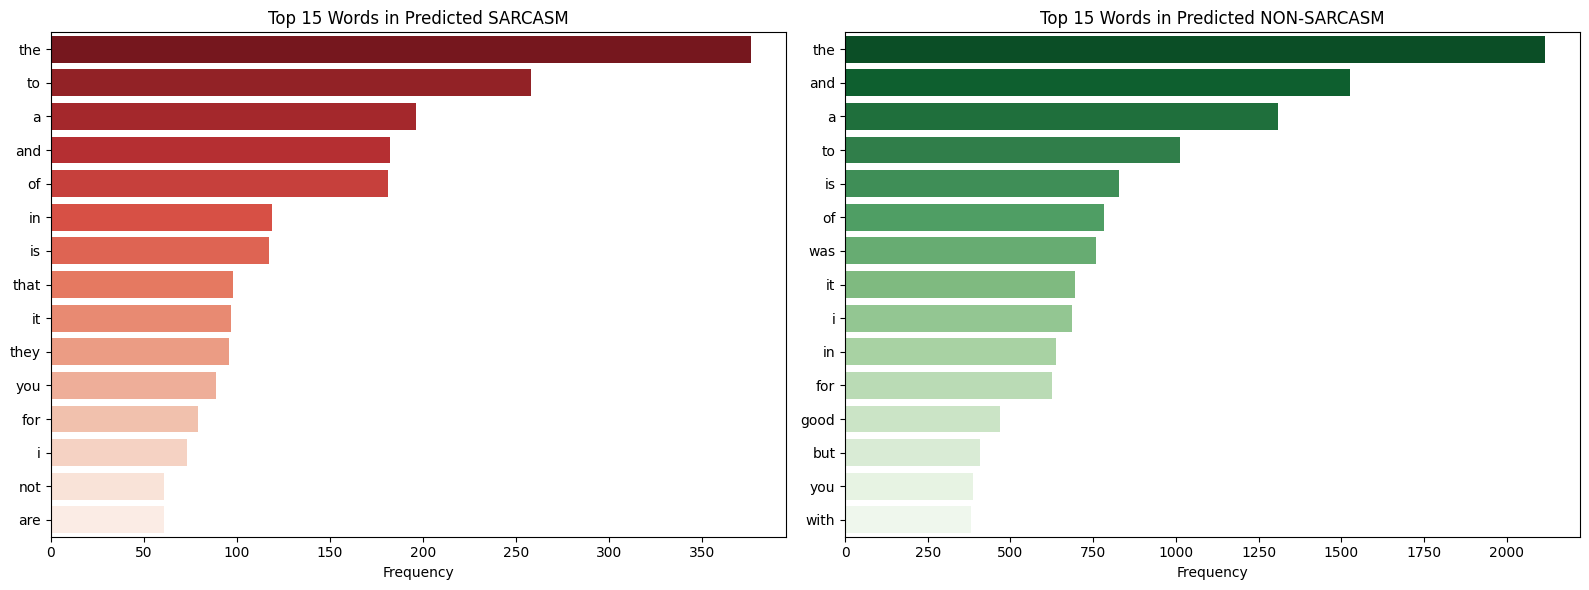

In [15]:
from collections import Counter
import seaborn as sns
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already present
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def plot_sarcasm_triggers(model, dataloader, tokenizer, device, top_n=15):
    model.eval()
    sarcastic_tokens = []
    regular_tokens = []

    print("Analyzing vocabulary...")
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=mask)
            preds = torch.argmax(outputs.logits, dim=1)

            # Iterate through batch
            for i in range(len(input_ids)):
                # Decode tokens to words
                tokens = tokenizer.convert_ids_to_tokens(input_ids[i])

                # Filter special tokens and stopwords
                clean_tokens = [
                    t.replace('Ġ', '').lower() for t in tokens
                    if t not in ['<s>', '</s>', '<pad>'] and t.isalpha() and t.lower() not in stop_words
                ]

                if preds[i] == 1: # Predicted Sarcastic
                    sarcastic_tokens.extend(clean_tokens)
                else: # Predicted Not Sarcastic
                    regular_tokens.extend(clean_tokens)

    # Count frequencies
    sarc_counts = Counter(sarcastic_tokens).most_common(top_n)
    reg_counts = Counter(regular_tokens).most_common(top_n)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Sarcastic Plot
    sns.barplot(x=[x[1] for x in sarc_counts], y=[x[0] for x in sarc_counts], ax=axes[0], palette="Reds_r")
    axes[0].set_title(f"Top {top_n} Words in Predicted SARCASM")
    axes[0].set_xlabel("Frequency")

    # Regular Plot
    sns.barplot(x=[x[1] for x in reg_counts], y=[x[0] for x in reg_counts], ax=axes[1], palette="Greens_r")
    axes[1].set_title(f"Top {top_n} Words in Predicted NON-SARCASM")
    axes[1].set_xlabel("Frequency")

    plt.tight_layout()
    plt.show()

plot_sarcasm_triggers(model, test_loader, tokenizer, device)

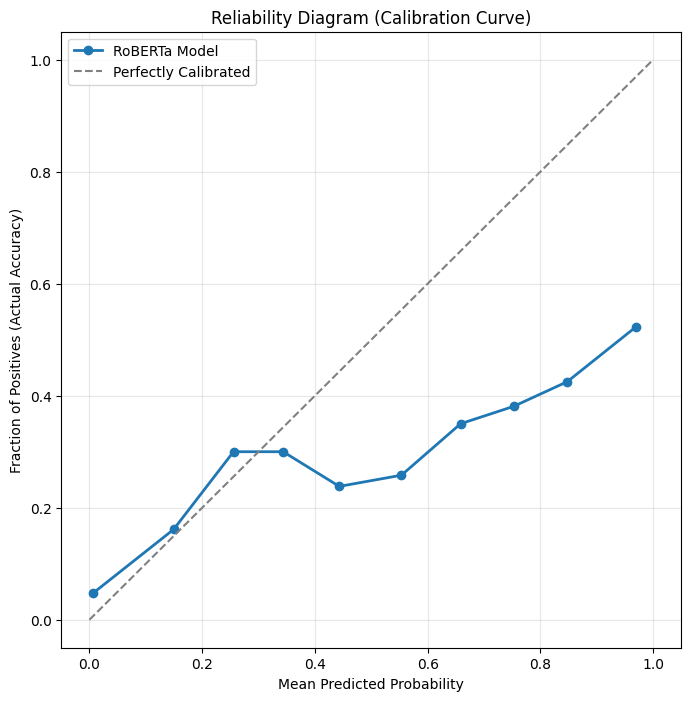

In [16]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(model, dataloader, device):
    model.eval()
    prob_true, prob_pred = [], []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=mask)
            # Get probability for Class 1 (Sarcasm)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)[:, 1]

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate calibration bins
    prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)

    plt.figure(figsize=(8, 8))
    plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='RoBERTa Model')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives (Actual Accuracy)')
    plt.title('Reliability Diagram (Calibration Curve)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_calibration_curve(model, test_loader, device)

In [17]:
def show_worst_predictions(model, dataloader, tokenizer, device, num_examples=5):
    model.eval()
    loss_fn = torch.nn.CrossEntropyLoss(reduction='none') # Don't average, keep loss per item
    worst_cases = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=mask)
            losses = loss_fn(outputs.logits, labels)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            for i in range(len(labels)):
                # We only care about WRONG predictions for this list
                if preds[i] != labels[i]:
                    worst_cases.append({
                        "text": tokenizer.decode(input_ids[i], skip_special_tokens=True),
                        "true_label": labels[i].item(),
                        "pred_label": preds[i].item(),
                        "confidence": probs[i][preds[i]].item(), # Confidence in the WRONG answer
                        "loss": losses[i].item()
                    })

    # Sort by Loss (Highest loss = Most confident wrong answer)
    worst_cases.sort(key=lambda x: x["loss"], reverse=True)

    print(f"\nTop {num_examples} 'Worst' Errors (Highest Loss):")
    print("These are examples where the model was confident but wrong.")
    print("=" * 80)

    labels_map = {0: "Not Sarcastic", 1: "Sarcastic"}

    for i, case in enumerate(worst_cases[:num_examples]):
        print(f"Rank {i+1} (Loss: {case['loss']:.4f})")
        print(f"Text:  {case['text']}")
        print(f"True:  {labels_map[case['true_label']]}")
        print(f"Pred:  {labels_map[case['pred_label']]} (Confidence: {case['confidence']*100:.1f}%)")
        print("-" * 80)

show_worst_predictions(model, test_loader, tokenizer, device)


Top 5 'Worst' Errors (Highest Loss):
These are examples where the model was confident but wrong.
Rank 1 (Loss: 7.5768)
Text:  Non veg is good option if you go here. Taste, quality & quantity all good per price.. good service n nice Ambience after upgrading. Can have a good time enjoying with your friends & family.. please do n't but fruit juice. It's the worst you can order it was like rasna!
True:  Sarcastic
Pred:  Not Sarcastic (Confidence: 99.9%)
--------------------------------------------------------------------------------
Rank 2 (Loss: 7.3818)
Text:  Surreal is an excellent restaurant and the food is superb and service is efficient however on my third visit in Autumn the room was very cold to the point of having to leave a scarf and jacket on. Two small RC with only one turned on is not going to heat a former church chapel and a projector screen slide of an open fire really does n't cut it. Unless the heating is improved it not the place to visit in Autumn and Winter unfortunat